In [3]:
import gc, os, random, pickle, time, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))
    
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_log_error as msle, mean_squared_error as mse
from sklearn.model_selection import KFold, train_test_split 
from sklearn.preprocessing import  OneHotEncoder, LabelEncoder
from tqdm import tqdm
pd.set_option('display.max_columns', 100)

In [4]:
'''减少内存使用'''

def reduce_mem_usage(df):
    '''迭代所有列，减少内存使用'''
    start_mem = df.memory_usage().sum() / (1024**2)
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def rmsle(y_true, y_predict):
    
    return np.sqrt(msle(y_true, y_predict))


In [5]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
bldg_metadata = pd.read_csv("./data/building_metadata.csv")
weather_train = pd.read_csv("./data/weather_train.csv")
weather_test = pd.read_csv("./data/weather_test.csv")
sample = pd.read_csv("./data/sample_submission.csv")

In [6]:
display(df_test.head(5))

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [7]:
df_test = df_test.drop(columns=['row_id'])

In [8]:

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
bldg_metadata = reduce_mem_usage(bldg_metadata)
weather_train =reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

df_train = df_train.merge(bldg_metadata, on='building_id', how='left')
df_test = df_test.merge(bldg_metadata, on='building_id', how='left')
df_train = df_train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
df_test = df_test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%
Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%


In [9]:
import gc
del weather_train, weather_test, bldg_metadata
gc.collect()

168

In [10]:
display(df_train.head(5))

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [11]:
display(df_test.head(5))

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609


In [12]:
print(df_train.shape)
print(df_test.shape)

(20216100, 16)
(41697600, 15)


In [13]:
# 将数据持久化
df_train.to_pickle('./df_train.pkl')
df_test.to_pickle('./df_test.pkl')
del df_train, df_test
gc.collect()


115

# 特征工程

In [26]:
df_train = pd.read_pickle('./df_train.pkl')
df_test = pd.read_pickle('./df_test.pkl')

In [27]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

In [30]:
# 1、抽取时间类特征
df_train['year'] = df_train['timestamp'].dt.year
df_train['month'] = df_train['timestamp'].dt.month
df_train['day'] = df_train['timestamp'].dt.day
df_train['hour'] = df_train['timestamp'].dt.hour
df_test['year'] = df_test['timestamp'].dt.year
df_test['month'] = df_test['timestamp'].dt.month
df_test['day'] = df_test['timestamp'].dt.day
df_test['hour'] = df_test['timestamp'].dt.hour

df_train['dayofweek'] = df_train['timestamp'].dt.dayofweek
df_test['dayofweek'] = df_test['timestamp'].dt.dayofweek

In [31]:
# Making age feature
df_train['age'] = df_train['year'] - df_train['year_built']
df_test['age'] = df_test['year'] - df_test['year_built']

# Making number of hours passed from start
new_df = df_train.groupby(by=['building_id'], as_index=False)['timestamp'].min()
new_df = new_df.rename(columns = {'timestamp': 'start_ts'})

df_train = df_train.merge(new_df, on = 'building_id', how='left')
df_test = df_test.merge(new_df, on = 'building_id', how='left')

df_train['hours_passed'] = (df_train['timestamp'] - df_train['start_ts']).dt.total_seconds()/3600
df_test['hours_passed'] = (df_test['timestamp'] - df_test['start_ts']).dt.total_seconds()/3600

In [33]:
# df_train = df_train.query('not(site_id==0 & timestamp<"2016-05-21 00:00:00")')
df_train = df_train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Missing value handling
cols = ['floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 
        'wind_direction', 'wind_speed']
df_train.loc[:, cols] = df_train.loc[:, cols].interpolate(axis=0)
df_test.loc[:, cols] = df_test.loc[:, cols].interpolate(axis=0)

In [15]:
# class NewFeatures:
#     """This class constructs features of min, max, median, mean, std_dev based on grouping columns"""
    
#     def __init__(self, feature, grouping_cols):
#         self.feature = feature
#         self.grouping_cols = grouping_cols
#         self.features = None
#         self.feature_mean = None
#         self.feature_median = None
#         self.feature_std_dev = None
#         self.feature_min = None
#         self.feature_max = None
        
#     def fetch_values(self, df):
#         self.feature_mean = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].mean().rename(columns={self.feature: f'{self.feature}_mean'})
#         self.feature_median = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].median().rename(columns={self.feature: f'{self.feature}_median'})
#         self.feature_std_dev = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].std().rename(columns={self.feature: f'{self.feature}_std_dev'})
#         self.feature_min = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].min().rename(columns={self.feature: f'{self.feature}_min'})
#         self.feature_max = df.groupby(by=self.grouping_cols, as_index=False)[self.feature].max().rename(columns={self.feature: f'{self.feature}_max'})
#         self.features = self.feature_mean
#         self.features[f'{self.feature}_median'] = self.feature_median[f'{self.feature}_median']
#         self.features[f'{self.feature}_std_dev'] = self.feature_std_dev[f'{self.feature}_std_dev']
#         self.features[f'{self.feature}_min'] = self.feature_min[f'{self.feature}_min']
#         self.features[f'{self.feature}_max'] = self.feature_max[f'{self.feature}_max']
    
#     def predict(self, df):
#         STEP = 100000
#         for i in tqdm(range(0, df.shape[0], STEP)):
#             df.loc[i:i+STEP-1,:] = df.loc[i:i+STEP-1,:].merge(self.features, on = self.grouping_cols)
#         return df

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19869886 entries, 103 to 20216099
Data columns (total 24 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
primary_use           category
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
year                  int64
month                 int64
day                   int64
hour                  int64
dayofweek             int64
age                   float64
start_ts              datetime64[ns]
hours_passed          float64
dtypes: category(1), datetime64[ns](2), float16(9), float32(1), float64(2), int16(1), int32(1), int64(5), int8(2)
memory usage: 2.1 GB


In [35]:
reduce_mem_usage(df_train)
reduce_mem_usage(df_test)

Memory usage of dataframe is 2103.38 MB
Memory usage after optimization is: 985.75 MB
Decreased by 53.1%
Memory usage of dataframe is 4254.95 MB
Memory usage after optimization is: 1909.53 MB
Decreased by 55.1%


,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,dayofweek,age,start_ts,hours_passed
0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,9.0,2016-01-01,8784.0
1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,13.0,2016-01-01,8784.0
2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,26.0,2016-01-01,8784.0
3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,15.0,2016-01-01,8784.0
4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,42.0,2016-01-01,8784.0
5,5,0,2017-01-01 00:00:00,0,Education,8000,2000.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,17.0,2016-01-01,8784.0
6,6,0,2017-01-01 00:00:00,0,Lodging/residential,27926,1981.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,36.0,2016-01-01,8784.0
7,7,0,2017-01-01 00:00:00,0,Education,121074,1989.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,28.0,2016-01-01,8784.0
8,7,1,2017-01-01 00:00:00,0,Education,121074,1989.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,28.0,2016-01-01,8784.0
9,8,0,2017-01-01 00:00:00,0,Education,60809,2003.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609,2017,1,1,0,6,14.0,2016-01-01,8784.0


In [37]:
df_train['meter_reading_log1p'] = np.log1p(df_train['meter_reading'])

In [39]:
df_group = df_train.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

df_train['building_mean'] = df_train['building_id'].map(building_mean)
df_train['building_median'] = df_train['building_id'].map(building_median)
df_train['building_min'] = df_train['building_id'].map(building_min)
df_train['building_max'] = df_train['building_id'].map(building_max)
df_train['building_std'] = df_train['building_id'].map(building_std)

In [40]:
# df_group = df_test.groupby('building_id')['meter_reading_log1p']
# building_mean = df_group.mean().astype(np.float16)
# building_median = df_group.median().astype(np.float16)
# building_min = df_group.min().astype(np.float16)
# building_max = df_group.max().astype(np.float16)
# building_std = df_group.std().astype(np.float16)

# df_test['building_mean'] = df_test['building_id'].map(building_mean)
# df_test['building_median'] = df_test['building_id'].map(building_median)
# df_test['building_min'] = df_test['building_id'].map(building_min)
# df_test['building_max'] = df_test['building_id'].map(building_max)
# df_test['building_std'] = df_test['building_id'].map(building_std)

KeyError: 'Column not found: meter_reading_log1p'

In [42]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [43]:
add_lag_feature(df_train, window=3)
add_lag_feature(df_train, window=72)

In [45]:
# add_lag_feature(df_test, window=3)
# add_lag_feature(df_test, window=72)
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,dayofweek,age,start_ts,hours_passed,meter_reading_log1p,building_mean,building_median,building_min,building_max,building_std,air_temperature_mean_lag3,air_temperature_max_lag3,air_temperature_min_lag3,air_temperature_std_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,cloud_coverage_min_lag3,cloud_coverage_std_lag3,dew_temperature_mean_lag3,dew_temperature_max_lag3,dew_temperature_min_lag3,dew_temperature_std_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_std_lag3,sea_level_pressure_mean_lag3,sea_level_pressure_max_lag3,sea_level_pressure_min_lag3,sea_level_pressure_std_lag3,wind_direction_mean_lag3,wind_direction_max_lag3,wind_direction_min_lag3,wind_direction_std_lag3,wind_speed_mean_lag3,wind_speed_max_lag3,wind_speed_min_lag3,wind_speed_std_lag3,air_temperature_mean_lag72,air_temperature_max_lag72,air_temperature_min_lag72,air_temperature_std_lag72,cloud_coverage_mean_lag72,cloud_coverage_max_lag72,cloud_coverage_min_lag72,cloud_coverage_std_lag72,dew_temperature_mean_lag72,dew_temperature_max_lag72,dew_temperature_min_lag72,dew_temperature_std_lag72,precip_depth_1_hr_mean_lag72,precip_depth_1_hr_max_lag72,precip_depth_1_hr_min_lag72,precip_depth_1_hr_std_lag72,sea_level_pressure_mean_lag72,sea_level_pressure_max_lag72,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
103,105,0,2016-01-01,23.303600,1,Education,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0,3.190624,4.316406,4.332031,3.191406,5.164062,0.318115,13.296875,13.296875,13.296875,0.0,0.735840,0.781738,0.689453,0.046143,11.101562,11.101562,11.101562,0.0,0.0,0.0,0.0,0.0,1023.0,1023.0,1023.0,4.768372e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.289062,13.296875,11.101562,0.864258,1.930664,6.0,0.0,2.726562,9.625000,11.101562,8.898438,0.824219,0.0,0.0,0.0,0.0,1022.5,1023.0,1022.0,0.400146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,106,0,2016-01-01,0.374600,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0,0.318163,0.887695,0.559082,0.000000,3.712891,0.967773,13.296875,13.296875,13.296875,0.0,0.781738,0.827637,0.735840,0.045898,11.101562,11.101562,11.101562,0.0,0.0,0.0,0.0,0.0,1023.0,1023.0,1023.0,4.768372e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.304688,13.296875,11.101562,0.872070,1.941406,6.0,0.0,2.718750,9.648438,11.101562,8.898438,0.841797,0.0,0.0,0.0,0.0,1022.5,1023.0,1022.0,0.404297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,106,3,2016-01-01,0.000000,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0,0.000000,0.887695,0.559082,0.000000,3.712891,0.967773,13.296875,13.296875,13.296875,0.0,0.827637,0.873535,0.781738,0.045898,11.101562,11.101562,11.101562,0.0,0.0,0.0,0.0,0.0,1023.0,1023.0,1023.0,4.768372e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.320312,13.296875,11.101562,0.879883,1.954102,6.0,0.0,2.712891,9.671875,11.101562,8.898438,0.858398,0.0,0.0,0.0,0.0,1022.5,1023.0,1022.0,0.407959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,107,0,2016-01-01,175.184006,1,Education,97532,2005.0,10.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,11.0,2016-01-01,0.0,5.171529,4.570312,5.781250,0.039703,6.382812,2.009766,13.296875,13.296875,13.296875,0.0,0.873535,0.919434,0.827637,0.045898,11.101562,11.101562,11.101562,0.0,0.0,0.0,0.0,0.0,1023.0,1023.0,1023.0,4.768372e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.335938,13.296875,11.101562,0.887207,1.966797,6.0,0.0,2.705078,9.695312,11.101562,8.898438,0.874512,0.0,0.0,0.0,0.0,1022.5,1023.0,1022.0,0.411133,0.0,0.0,0.0,0.0,0.0,0.0

In [46]:
# df.test.head()
df_train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'year', 'month', 'day', 'hour', 'dayofweek', 'age',
       'start_ts', 'hours_passed', 'meter_reading_log1p', 'building_mean',
       'building_median', 'building_min', 'building_max', 'building_std',
       'air_temperature_mean_lag3', 'air_temperature_max_lag3',
       'air_temperature_min_lag3', 'air_temperature_std_lag3',
       'cloud_coverage_mean_lag3', 'cloud_coverage_max_lag3',
       'cloud_coverage_min_lag3', 'cloud_coverage_std_lag3',
       'dew_temperature_mean_lag3', 'dew_temperature_max_lag3',
       'dew_temperature_min_lag3', 'dew_temperature_std_lag3',
       'precip_depth_1_hr_mean_lag3', 'precip_depth_1_hr_max_lag3',
       'precip_depth_1_hr_min_lag3', 'precip_depth_1_hr_std_lag3

In [47]:
cat_cols = ['meter', 'primary_use', 'site_id', 'building_id']
for col in cat_cols:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [48]:
reduce_mem_usage(df_train)

Memory usage of dataframe is 3373.42 MB
Memory usage after optimization is: 3335.53 MB
Decreased by 1.1%


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,year,month,day,hour,dayofweek,age,start_ts,hours_passed,meter_reading_log1p,building_mean,building_median,building_min,building_max,building_std,air_temperature_mean_lag3,air_temperature_max_lag3,air_temperature_min_lag3,air_temperature_std_lag3,cloud_coverage_mean_lag3,cloud_coverage_max_lag3,cloud_coverage_min_lag3,cloud_coverage_std_lag3,dew_temperature_mean_lag3,dew_temperature_max_lag3,dew_temperature_min_lag3,dew_temperature_std_lag3,precip_depth_1_hr_mean_lag3,precip_depth_1_hr_max_lag3,precip_depth_1_hr_min_lag3,precip_depth_1_hr_std_lag3,sea_level_pressure_mean_lag3,sea_level_pressure_max_lag3,sea_level_pressure_min_lag3,sea_level_pressure_std_lag3,wind_direction_mean_lag3,wind_direction_max_lag3,wind_direction_min_lag3,wind_direction_std_lag3,wind_speed_mean_lag3,wind_speed_max_lag3,wind_speed_min_lag3,wind_speed_std_lag3,air_temperature_mean_lag72,air_temperature_max_lag72,air_temperature_min_lag72,air_temperature_std_lag72,cloud_coverage_mean_lag72,cloud_coverage_max_lag72,cloud_coverage_min_lag72,cloud_coverage_std_lag72,dew_temperature_mean_lag72,dew_temperature_max_lag72,dew_temperature_min_lag72,dew_temperature_std_lag72,precip_depth_1_hr_mean_lag72,precip_depth_1_hr_max_lag72,precip_depth_1_hr_min_lag72,precip_depth_1_hr_std_lag72,sea_level_pressure_mean_lag72,sea_level_pressure_max_lag72,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
103,105,0,2016-01-01 00:00:00,23.303600,1,Education,50623,NaN,5.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0,3.191406,4.316406,4.332031,3.191406,5.164062,0.318115,13.296875,13.296875,13.296875,0.000000,0.735840,0.781738,0.689453,4.614258e-02,11.101562,11.101562,11.101562,0.000000,0.0,0.0,0.0,0.0,1023.0,1023.0,1023.0,4.768372e-07,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,12.289062,13.296875,11.101562,0.864258,1.930664,6.000000,0.0,2.726562,9.625000,11.101562,8.898438,0.824219,0.0,0.0,0.0,0.0,1022.5,1023.0,1022.0,0.400146,0.000000,0.0,0.0,0.0000,0.00000,0.000000,0.0,0.000000
104,106,0,2016-01-01 00:00:00,0.374600,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0,0.318115,0.887695,0.559082,0.000000,3.712891,0.967773,13.296875,13.296875,13.296875,0.000000,0.781738,0.827637,0.735840,4.589844e-02,11.101562,11.101562,11.101562,0.000000,0.0,0.0,0.0,0.0,1023.0,1023.0,1023.0,4.768372e-07,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,12.304688,13.296875,11.101562,0.872070,1.941406,6.000000,0.0,2.718750,9.648438,11.101562,8.898438,0.841797,0.0,0.0,0.0,0.0,1022.5,1023.0,1022.0,0.404297,0.000000,0.0,0.0,0.0000,0.00000,0.000000,0.0,0.000000
105,106,3,2016-01-01 00:00:00,0.000000,1,Education,5374,NaN,4.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,NaN,2016-01-01,0.0,0.000000,0.887695,0.559082,0.000000,3.712891,0.967773,13.296875,13.296875,13.296875,0.000000,0.827637,0.873535,0.781738,4.589844e-02,11.101562,11.101562,11.101562,0.000000,0.0,0.0,0.0,0.0,1023.0,1023.0,1023.0,4.768372e-07,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,12.320312,13.296875,11.101562,0.879883,1.954102,6.000000,0.0,2.712891,9.671875,11.101562,8.898438,0.858398,0.0,0.0,0.0,0.0,1022.5,1023.0,1022.0,0.407959,0.000000,0.0,0.0,0.0000,0.00000,0.000000,0.0,0.000000
106,107,0,2016-01-01 00:00:00,175.184006,1,Education,97532,2005.0,10.0,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609,2016,1,1,0,4,11.0,2016-01-01,0.0,5.171875,4.570312,5.781250,0.039703,6.382812,2.009766,13.296875,13.296875,13.296875,0.000000,0.873535,0.919434,0.827637,4.589844e-02,11.101562,11.101562,11.101562,0.000000,0.0,0.0,0.0,0.0,1023.0,102

In [52]:
# drop_columns = ['timestamp', 'year',  'meter_reading', 'start_ts']
# df_train = df_train.drop(columns= drop_columns, axis=1)
import gc
gc.collect()

4531

# 模型预测

In [58]:
gc.collect()
# Create input and target
# y_train = df_train['meter_reading_log1p']
# y_train = np.log1p(y_train)
# df_train = df_train.drop(columns=['meter_reading', 'meter_reading_log1p'])
# y_val = df_val['meter_reading']
# df_val = df_val.drop(columns=['meter_reading'])

# Make validation set based on train_test_split
df_train, df_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=42)

# Drop timestamp because model does not accept
# df_train = df_train.drop(columns=['timestamp', 'start_ts'])
# df_val = df_val.drop(columns=['timestamp', 'start_ts'])
# df_test = df_test.drop(columns=['timestamp', 'start_ts'])

# Model
lgbmr = LGBMRegressor(random_state=10)
lgbmr.fit(df_train, y_train)
y_predict = lgbmr.predict(df_val)
score = np.sqrt(mse(y_val, y_predict))
# score = rmsle(y_val, y_predict)
print(f"score: {score}")

OSError: exception: access violation reading 0x00000000000002A8

# 简单融合

In [45]:
# Half and half learning
X_1st_half = df_train[:int(df_train.shape[0]/2)]
y_1st_half = y_train[:int(df_train.shape[0]/2)]
X_2nd_half = df_train[int(df_train.shape[0]/2):]
y_2nd_half = y_train[int(df_train.shape[0]/2):]

lgbmr_1st_half = LGBMRegressor(random_state=10)
lgbmr_2nd_half = LGBMRegressor(random_state=10)
lgbmr_1st_half.fit(X_1st_half, y_1st_half)
lgbmr_2nd_half.fit(X_2nd_half, y_2nd_half)
y_predict_1 = lgbmr_1st_half.predict(df_val)
y_predict_2 = lgbmr_2nd_half.predict(df_val)
y_predict_1_2 = (pd.Series(data=y_predict_1, name='prediction_1') + pd.Series(data=y_predict_2, name='prediction_2'))/2
score = np.sqrt(mse(y_val, y_predict_1_2))
print(f"score: {score}")

score: 0.9162380257770243


In [46]:
# Saving model
filename = 'lgbm_model1.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

filename = 'lgbmr_1st_half.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
lgbmr_1st_half = pickle.load(open(filename, 'rb'))
filename = 'lgbmr_2nd_half.pickle'
pickle.dump(lgbmr, open(filename, 'wb'))
# load the model from disk
lgbmr_2nd_half = pickle.load(open(filename, 'rb'))

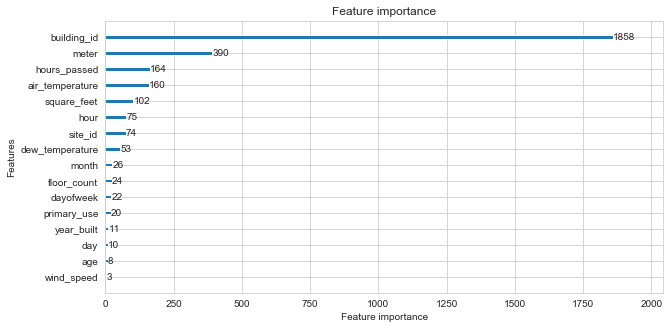

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(lgbmr, ax=ax)

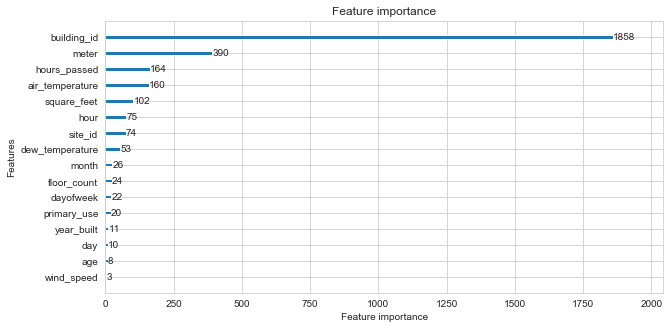

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(lgbmr_1st_half, ax=ax)

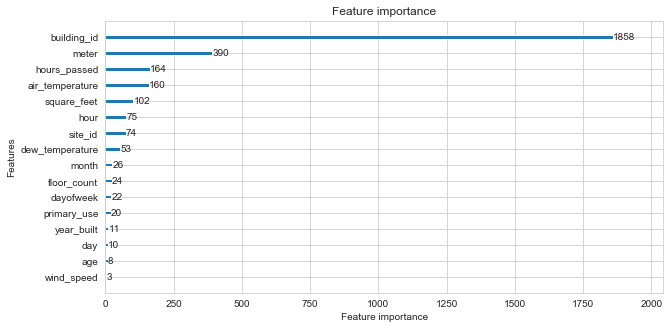

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(lgbmr_2nd_half, ax=ax)

In [56]:
del df_train, df_val, y_train, y_val, lgbmr
gc.collect()

2881

In [57]:

STEP = 1000000
y_test_predict = []
for i in range(0, df_test.shape[0], STEP):
    batch_prediction = lgbmr_1st_half.predict(df_test.loc[i:i+STEP-1,:])
    y_test_predict.append(list(batch_prediction))
y_test_1st_half = []
for predictions in y_test_predict:
    y_test_1st_half = y_test_1st_half + predictions
    
STEP = 1000000
y_test_predict = []
for i in range(0, df_test.shape[0], STEP):
    batch_prediction = lgbmr_2nd_half.predict(df_test.loc[i:i+STEP-1,:])
    y_test_predict.append(list(batch_prediction))
y_test_2nd_half = []

for predictions in y_test_predict:
    y_test_2nd_half = y_test_2nd_half + predictions
    


In [58]:
sample['meter_reading'] = (pd.Series(data=y_test_1st_half, name='pred_1st_half') + 
                           pd.Series(data=y_test_2nd_half, name='pred_2nd_half'))/2 

In [59]:
from math import e
samplee['meter_reading']  = e** sample['meter_reading'] - 1
sample.to_csv("submission_ligbm.csv", index=False, float_format='%.4f')